In [1]:
import sys
import os
from pathlib import Path
project_dir = Path(os.path.abspath('')).parent
sys.path.insert(0, project_dir.as_posix())

from tqdm import trange, tqdm
import numpy as np
import torch
from matplotlib import  pyplot as plt
from cs336_basics.nn_336 import TransformerLM
from cs336_basics.train import AdamW, cross_entropy, save_checkpoint, load_data, load_checkpoint, get_lr_cosine_schedule, gradient_clipping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

In [2]:
tokens = np.load(
    project_dir.joinpath("data", "TinyStoriesV2-GPT4-train-encoded.npy"), mmap_mode="r"
)

In [3]:
def train(
    model: TransformerLM,
    optimizer: AdamW,
    epochs,
    batch_size,
    T_w,
    T_c,
    checkpoint_dir=None,
    save_every=50,
):
    losses = optimizer.state["losses"]
    if checkpoint_dir is not None:
        checkpoint_dir = Path(checkpoint_dir)
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
    for _ in trange(epochs):
        epoch = optimizer.state["epoch"] + 1
        optimizer.param_groups[0]["lr"] = get_lr_cosine_schedule(
            epoch,
            (optimizer.state["init_lr"] / 10, optimizer.state["init_lr"]),
            T_w=T_w,
            T_c=T_c,
        )
        x, target = load_data(tokens, batch_size, model.max_seq_len, device=device)
        pred = model(x)
        loss = cross_entropy(pred.view(-1, pred.shape[-1]), target.view(-1))

        optimizer.zero_grad()
        loss.backward()
        # gradient_clipping(model.parameters())
        optimizer.step()

        del x
        del target

        losses.append(loss.item())
        if epoch % save_every == 0:
            if checkpoint_dir is not None:
                save_checkpoint(
                    model,
                    optimizer,
                    epoch,
                    (checkpoint_dir / f"checkpoint_epoch_{epoch}.pt").as_posix(),
                )
            tqdm.write(f"----\nEpoch [{epoch}/{epochs}], Loss: {losses[-1]:.4f}\n")
            fig = plt.figure(figsize=(5, 1.5))
            ax = fig.add_axes(111)
            ax.plot(np.arange(epoch), losses)
            ax.set_xlabel('epoch')
            ax.set_ylabel('loss')
            plt.show()

In [4]:
model = TransformerLM(
    vocab_size=10000,
    num_layers=4,
    num_heads=16,
    d_model=512,
    d_ff=1344,
    max_seq_len=256,
    Theta=10000,
    device=device,
)
optimizer = AdamW(
    model.parameters(), lr=0.001, betas=(0.9, 0.95), eps=1e-8, weight_decay=1e-2
)

In [7]:
import pickle
load_checkpoint(project_dir / "checkpoints" / "checkpoint_batch_size_128_epoch_3400.pt", model, optimizer)
with open('/home/ztzhu/AI/CS336/assignment1-basics/data/train_bpe_TinyStoriesV2-GPT4-train.pkl', "rb") as f:
    result = pickle.load(f)
vocab = result["vocab"]

for seed in [5, 6]:
    np.random.seed(5)
    torch.manual_seed(seed)
    x, target = load_data(tokens, 1, 50, device=device)
    x = x[0]
    target = target[0]
    target = ''.join([vocab[i].decode() for i in target.detach().cpu().numpy()])
    result = model.decode(x, vocab, max_token_num=100)
    if seed == 5:
        print(f"target:\n{target}")
    print(f"-----\nsequel:\n{result}")

 96%|█████████▌| 96/100 [00:00<00:00, 380.58it/s]


target:
 mud pies with his hands. One day, Tim saw his mom wash her hands with soap and water. He thought it was fun and wanted to try it too.
Tim went inside and found an empty sink. He turned on the water and put
-----
sequel:
 started to play with the soap. He made a big splash and splashed around. Tim laughed and splashed in the water. He had so much fun playing with the soap.
But then, something unexpected happened. The soap started to talk! It said, "Thank you for playing with me, Tim. I am a magic soap!" Tim was very surprised. He had never seen a magic soap before. He played with the magic soap all day and had lots of fun.
<|endoftext|>


 96%|█████████▌| 96/100 [00:00<00:00, 379.51it/s]


-----
sequel:
 started to play with the soap. He made a big splash and splashed around. Tim laughed and splashed in the water. He was having so much fun.
But then, something unexpected happened. The water started to move! Tim was scared and didn't know what to do. He looked around and saw a big, friendly dog. The dog had been hiding in the water! Tim was so happy and surprised. He played with the dog and the soap all day long.
<|endoftext|>


  3%|▎         | 99/3500 [01:05<36:48,  1.54it/s]

----
Epoch [100/3500], Loss: 5.7074



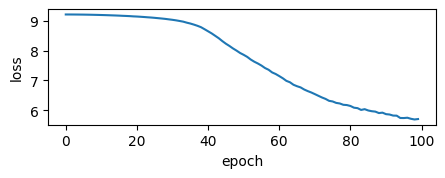

  6%|▌         | 199/3500 [02:11<35:48,  1.54it/s]

----
Epoch [200/3500], Loss: 4.0376



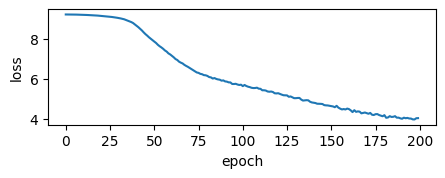

  9%|▊         | 299/3500 [03:16<34:48,  1.53it/s]

----
Epoch [300/3500], Loss: 3.3623



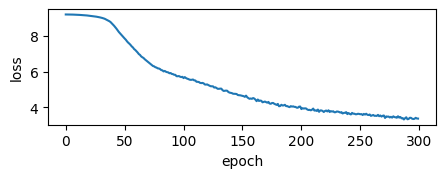

 11%|█▏        | 399/3500 [04:22<33:47,  1.53it/s]

----
Epoch [400/3500], Loss: 2.9777



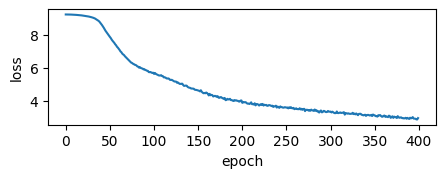

 14%|█▍        | 499/3500 [05:28<32:45,  1.53it/s]

----
Epoch [500/3500], Loss: 2.6526



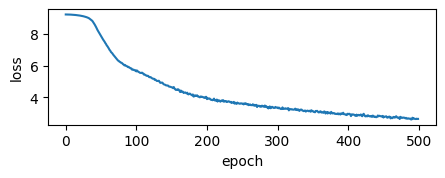

 17%|█▋        | 599/3500 [06:33<31:39,  1.53it/s]

----
Epoch [600/3500], Loss: 2.4606



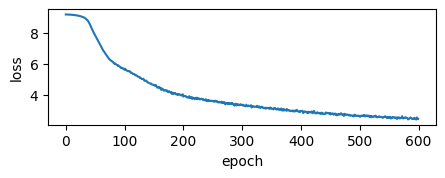

 20%|█▉        | 699/3500 [07:39<30:34,  1.53it/s]

----
Epoch [700/3500], Loss: 2.3296



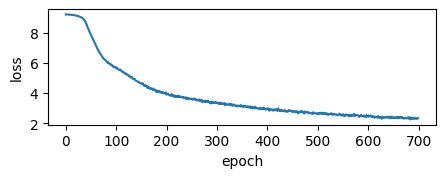

 23%|██▎       | 799/3500 [08:45<29:27,  1.53it/s]

----
Epoch [800/3500], Loss: 2.1175



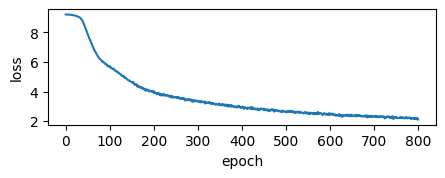

 26%|██▌       | 899/3500 [09:51<28:24,  1.53it/s]

----
Epoch [900/3500], Loss: 2.0365



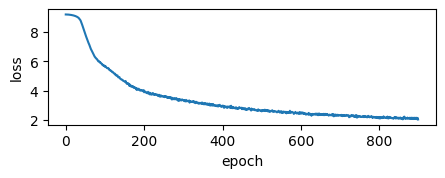

 29%|██▊       | 999/3500 [10:57<27:16,  1.53it/s]

----
Epoch [1000/3500], Loss: 2.0434



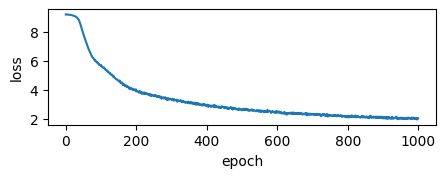

 31%|███▏      | 1099/3500 [12:03<26:12,  1.53it/s]

----
Epoch [1100/3500], Loss: 1.9666



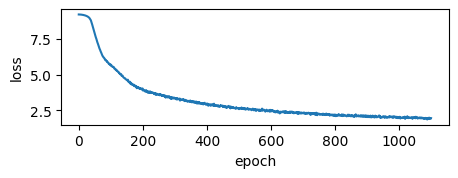

 34%|███▍      | 1199/3500 [13:08<25:06,  1.53it/s]

----
Epoch [1200/3500], Loss: 1.8591



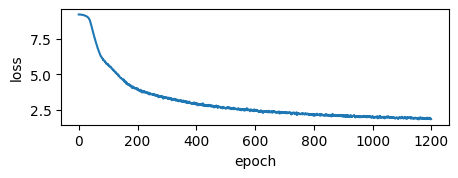

 37%|███▋      | 1299/3500 [14:14<24:01,  1.53it/s]

----
Epoch [1300/3500], Loss: 1.8748



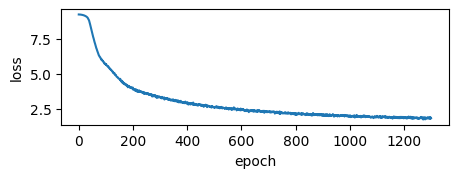

 40%|███▉      | 1399/3500 [15:20<22:55,  1.53it/s]

----
Epoch [1400/3500], Loss: 1.9052



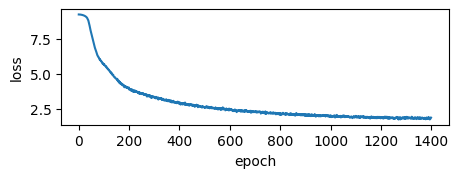

 43%|████▎     | 1499/3500 [16:26<21:50,  1.53it/s]

----
Epoch [1500/3500], Loss: 1.8730



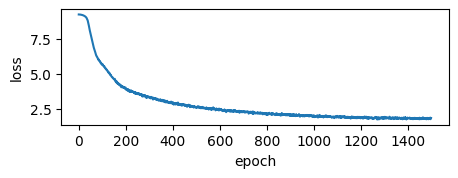

 46%|████▌     | 1599/3500 [17:32<20:44,  1.53it/s]

----
Epoch [1600/3500], Loss: 1.8320



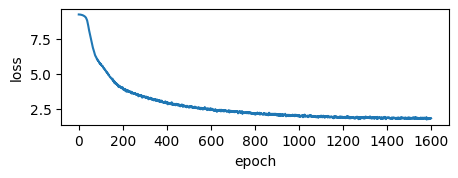

 49%|████▊     | 1699/3500 [18:37<19:39,  1.53it/s]

----
Epoch [1700/3500], Loss: 1.7690



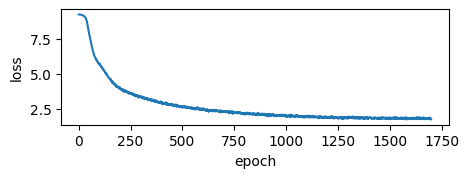

 51%|█████▏    | 1799/3500 [19:43<18:34,  1.53it/s]

----
Epoch [1800/3500], Loss: 1.8291



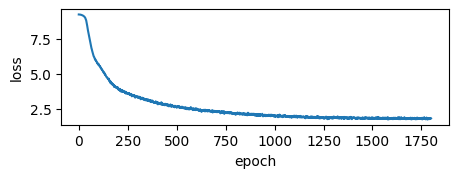

 54%|█████▍    | 1899/3500 [20:49<17:27,  1.53it/s]

----
Epoch [1900/3500], Loss: 1.7776



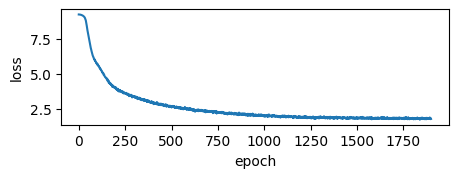

 57%|█████▋    | 1999/3500 [21:55<16:22,  1.53it/s]

----
Epoch [2000/3500], Loss: 1.7388



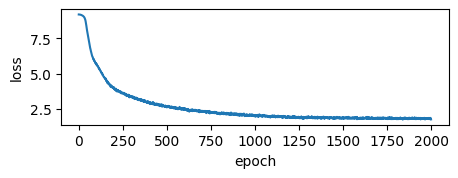

 60%|█████▉    | 2099/3500 [23:01<15:16,  1.53it/s]

----
Epoch [2100/3500], Loss: 1.7733



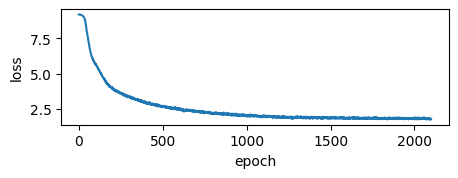

 63%|██████▎   | 2199/3500 [24:06<14:12,  1.53it/s]

----
Epoch [2200/3500], Loss: 1.8131



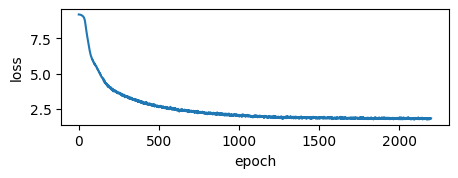

 66%|██████▌   | 2299/3500 [25:12<13:05,  1.53it/s]

----
Epoch [2300/3500], Loss: 1.7428



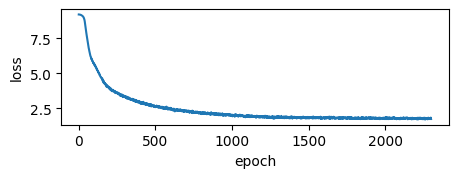

 69%|██████▊   | 2399/3500 [26:18<12:00,  1.53it/s]

----
Epoch [2400/3500], Loss: 1.7616



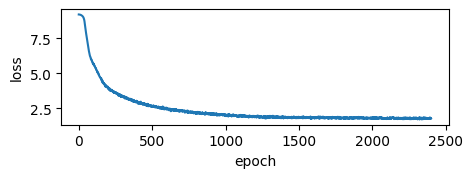

 71%|███████▏  | 2499/3500 [27:24<10:55,  1.53it/s]

----
Epoch [2500/3500], Loss: 1.7199



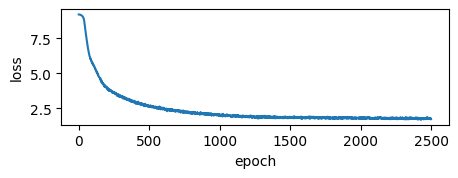

 74%|███████▍  | 2599/3500 [28:30<09:49,  1.53it/s]

----
Epoch [2600/3500], Loss: 1.7446



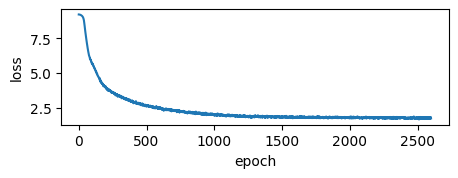

 77%|███████▋  | 2699/3500 [29:35<08:44,  1.53it/s]

----
Epoch [2700/3500], Loss: 1.7895



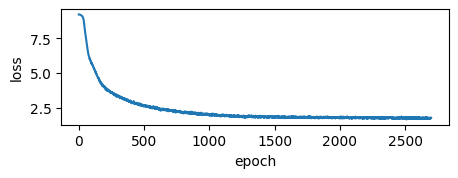

 80%|███████▉  | 2799/3500 [30:41<07:39,  1.53it/s]

----
Epoch [2800/3500], Loss: 1.7608



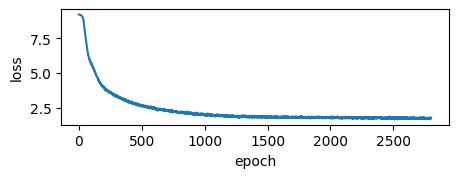

 83%|████████▎ | 2899/3500 [31:47<06:33,  1.53it/s]

----
Epoch [2900/3500], Loss: 1.7328



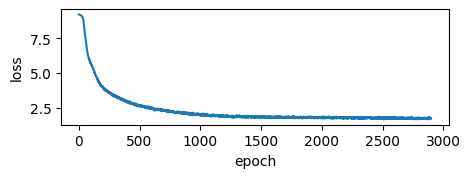

 86%|████████▌ | 2999/3500 [32:53<05:28,  1.53it/s]

----
Epoch [3000/3500], Loss: 1.7295



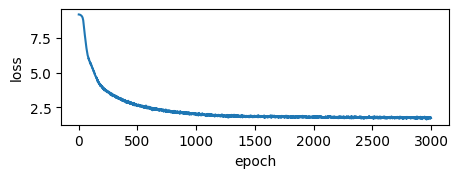

 89%|████████▊ | 3099/3500 [33:59<04:22,  1.53it/s]

----
Epoch [3100/3500], Loss: 1.7287



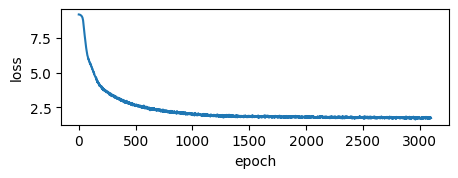

 91%|█████████▏| 3199/3500 [35:05<03:17,  1.53it/s]

----
Epoch [3200/3500], Loss: 1.6902



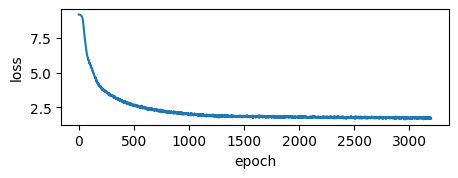

 91%|█████████▏| 3200/3500 [35:05<03:46,  1.32it/s]

In [ ]:
train(
    model,
    optimizer,
    epochs=3500,
    batch_size=128,
    T_w=500,
    T_c=1500,
    checkpoint_dir=project_dir / "checkpoints_128",
    save_every=100,
)